In [1]:
%reload_ext autoreload
%autoreload 2

import time
from tqdm import tqdm
import numpy as np
import scipy as sp
import torch
import torch.nn.functional as F
from torch import nn
from torchvision.transforms import v2 as transforms

from matplotlib import pyplot as plt

from networkAlignmentAnalysis.models.registry import get_model
from networkAlignmentAnalysis.datasets import get_dataset
from networkAlignmentAnalysis.experiments.registry import get_experiment
from networkAlignmentAnalysis import utils
from networkAlignmentAnalysis import files
from networkAlignmentAnalysis import train

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using device: ', DEVICE)

using device:  cuda


In [3]:
# TODO
# 1.1. include additional AlignmentModel methods stored in extra class in base model

# 4. Rewrite existing analysis pipelines
# 5. SLURM!!!!

# Figure out why convolutional alignment measurement is slow...
# still working on if it's possible to speed up measure_alignment for convolutional layers

# Basic alignment_comparison Analyses (or maybe for alignment_stats):
# - compare initial to final alignment...
# - compare initial alignment to delta weight norm...
# - observe alignment of delta weight
# - compare alignment to outgoing delta weight norm!

# Eigenfeature analyses:
# done: - start by just looking at amplitude of activity on each eigenvector within each layer
# - Determine contribution of each eigenfeature on performance with a eigenvector dropout experiment
# - Measure beta_adversarial (figure out how adversarial examples map onto eigenvectors)

# alignmentShaping.ipynb has an adversarial experiment worth looking at

In [2]:
model_name = 'MLP'
dataset_name = 'MNIST'

net = get_model(model_name, build=True, dataset=dataset_name).to(DEVICE)
dataset = get_dataset(dataset_name, build=True, transform_parameters=net, device=DEVICE)

beta, eigenvalue, eigenvector = net.measure_eigenfeatures(dataset.test_loader, centered=False)

100%|██████████| 10/10 [00:02<00:00,  3.45it/s]


don't dropout by setting values to 0!


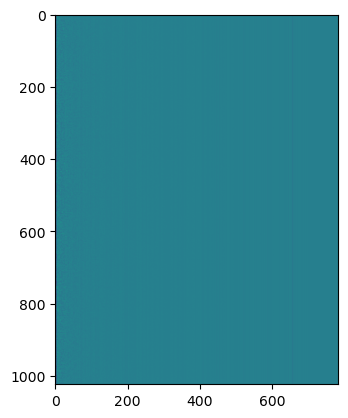

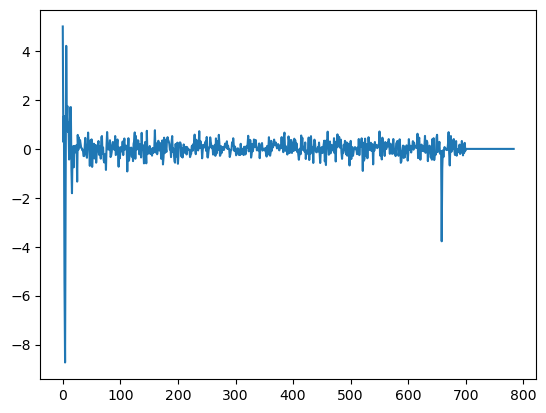

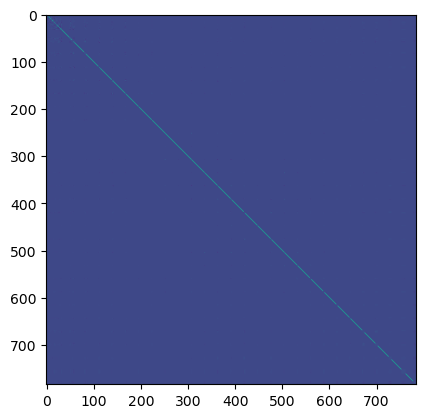

ValueError: need some linear algebra for projecting out the activity of one of the eigenvectors

In [4]:
batch = next(iter(dataset.test_loader))
images, labels = dataset.unwrap_batch(batch)

out = net.forward_eigenvector_dropout(images, eigenvector, [range(700, 784)], [0])

In [13]:
results = train.test([net], dataset, train_set=False)

100%|██████████| 10/10 [00:00<00:00, 25.08it/s]


In [19]:
# next steps:
# - finish eigenvector dropout methods -- need to do some linear algebra and decide how to renormalize
# - create method for using the above method in train.py
# - integrate into alignment_stats and observe results!!!

In [7]:
from contextlib import contextmanager

with nullcontext:
    print('hi')

AttributeError: __enter__